In [23]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import rasterio
import xarray as xr
import geopandas as gpd
import rioxarray
from rasterio.enums import Resampling
import os
import joblib
from joblib import Parallel, delayed
%config InlineBackend.figure_format = 'retina'

单位是million dollar

In [2]:
test_frame = xr.open_dataset(r"E:\risk_evaluation\scripts\outputs\GDP\2000GDP_resampled.nc",decode_coords="all")
test_frame

<xarray.Dataset>
Dimensions:      (y: 1800, x: 1560)
Coordinates:
  * y            (y) float64 43.0 42.99 42.98 42.97 ... 28.03 28.02 28.01 28.01
  * x            (x) float64 110.0 110.0 110.0 110.0 ... 123.0 123.0 123.0 123.0
    spatial_ref  int32 ...
Data variables:
    band_data    (y, x) float32 ...

In [3]:
study_area_gpdframe = gpd.read_file(r"E:\risk_evaluation\scripts\datas\BOARDER\extracted\华北平原地市级\华北平原地市级.shp")
study_area_gpdframe =  study_area_gpdframe.dissolve()

In [4]:
gdp_array = []
for i in range(2000, 2016):
    filename = r"E:\risk_evaluation\scripts\outputs\GDP\\"+ str(i)+"GDP_resampled.nc"
    data_frame = xr.open_dataset(filename,decode_coords="all")
    data_array = data_frame.rio.clip(study_area_gpdframe.geometry, study_area_gpdframe.crs, drop=True).to_array()[0,:,:]
    gdp_array.append(data_array)

gdp_risk_array = np.array(gdp_array)
gdp_risk_array.shape

(16, 1587, 1482)

In [5]:
def million_dollar_to_RMB(million_dollar):
    return million_dollar*6.5*1000000

In [6]:
gdp_std = np.array([np.nanstd(gdp_risk_array[i]) for i in range(16)])
gdp_std.shape

(16,)

In [7]:
gdp_mean = np.array([np.nanmean(gdp_risk_array[i]) for i in range(16)])
gdp_mean.shape

(16,)

In [8]:
gdp_standards = np.array([gdp_mean/2,gdp_mean/2+gdp_std,gdp_mean/2+gdp_std*2,gdp_mean/2+gdp_std*3])
gdp_standards

array([[ 1.0555328,  1.1173855,  1.2345362,  1.3433672,  1.4924845,
         1.6071049,  1.7716336,  1.9228345,  2.0430372,  2.171669 ,
         2.4245152,  2.6031117,  2.685216 ,  2.859796 ,  2.9939601,
         3.0738063],
       [ 6.2478046,  6.6144757,  7.3106184,  7.823047 ,  8.732481 ,
         9.397021 , 10.317255 , 11.151965 , 11.804134 , 12.522729 ,
        13.812328 , 14.761972 , 15.158751 , 16.051039 , 16.809576 ,
        17.261158 ],
       [11.440076 , 12.111567 , 13.386701 , 14.302728 , 15.972478 ,
        17.186937 , 18.862875 , 20.381096 , 21.565231 , 22.873789 ,
        25.20014  , 26.920834 , 27.632286 , 29.242281 , 30.625193 ,
        31.44851  ],
       [16.632347 , 17.608658 , 19.462784 , 20.782408 , 23.212475 ,
        24.976854 , 27.408497 , 29.610228 , 31.326328 , 33.22485  ,
        36.58795  , 39.079697 , 40.10582  , 42.43352  , 44.44081  ,
        45.63586  ]], dtype=float32)

In [9]:
gdp_risk_array = np.zeros_like(gdp_array)

In [10]:
for i in range(16):
    gdp_risk_array[i] = np.where(gdp_array[i] > gdp_standards[3][i], 0.9,
                             np.where(gdp_array[i] > gdp_standards[2][i], 0.8,
                                      np.where(gdp_array[i] > gdp_standards[1][i], 0.7,
                                               np.where(gdp_array[i] > gdp_standards[0][i], 0.6, 0.5))))


万元RMB为单位的GDP划分标准

In [11]:
gdp_standards_RMB = million_dollar_to_RMB(gdp_standards)
for i in gdp_standards_RMB:
    print(i/10000)

[ 686.09633446  726.30057335  802.44846344  873.18868637  970.11489868
 1044.6182251  1151.56183243 1249.842453   1327.97412872 1411.58485413
 1575.93488693 1692.02270508 1745.39031982 1858.86745453 1946.07410431
 1997.97401428]
[ 4061.07292175  4299.40910339  4751.90200806  5084.98077393
  5676.11274719  6108.06388855  6706.21566772  7248.77700806
  7672.68753052  8139.77355957  8978.01361084  9595.28198242
  9853.18756104 10433.17489624 10926.22451782 11219.75250244]
[ 7436.0496521   7872.51815796  8701.35574341  9296.77276611
 10382.1105957  11171.509552   12260.86883545 13247.71270752
 14017.40112305 14867.96264648 16380.09033203 17498.54125977
 17960.98632812 19007.48291016 19906.37512207 20441.53137207]
[10811.02600098 11445.62759399 12650.80947876 13508.5647583
 15088.10882568 16234.95483398 17815.52276611 19246.64764404
 20362.11395264 21596.1517334  23782.1685791  25401.80358887
 26068.78356934 27581.79016113 28886.52648926 29663.30871582]


读取人口数据

In [12]:
pop_array = []
for i in range(2000, 2016):
    filename = r"E:\risk_evaluation\scripts\outputs\POPULAR\chn_pd_"+ str(i)+"_1km.nc"
    data_frame = xr.open_dataset(filename,decode_coords="all")
    data_frame = data_frame.rio.reproject_match(test_frame)
    data_array = data_frame.rio.clip(study_area_gpdframe.geometry, study_area_gpdframe.crs, drop=True).to_array()[0,:,:]

    pop_array.append(data_array)

pop_risk_array = np.array(pop_array)
pop_risk_array.shape

(16, 1587, 1482)

In [13]:
pop_std = np.array([np.nanstd(pop_risk_array[i]) for i in range(16)])
pop_std.shape

(16,)

In [14]:
pop_mean = np.array([np.nanmean(pop_risk_array[i]) for i in range(16)])
pop_mean.shape

(16,)

In [15]:
pop_standards = np.array([pop_mean/2,pop_mean/2+pop_std,pop_mean/2+pop_std*2,pop_mean/2+pop_std*3])
pop_standards

array([[ 261.48203,  263.08932,  264.6561 ,  266.3052 ,  268.0118 ,
         269.7769 ,  271.55524,  273.39716,  275.2927 ,  277.22336,
         279.22195,  281.2165 ,  283.3387 ,  285.46024,  287.6418 ,
         289.88867],
       [1656.9058 , 1684.4835 , 1695.1082 , 1703.3793 , 1729.4835 ,
        1756.6722 , 1775.176  , 1799.8611 , 1827.0894 , 1856.9661 ,
        1885.415  , 1919.0354 , 1957.8594 , 1986.1263 , 2010.3552 ,
        2044.7269 ],
       [3052.3293 , 3105.8777 , 3125.56   , 3140.4534 , 3190.955  ,
        3243.5676 , 3278.7966 , 3326.325  , 3378.886  , 3436.7087 ,
        3491.6082 , 3556.8542 , 3632.38   , 3686.7925 , 3733.0686 ,
        3799.5652 ],
       [4447.753  , 4527.272  , 4556.012  , 4577.5273 , 4652.427  ,
        4730.463  , 4782.4175 , 4852.7886 , 4930.682  , 5016.451  ,
        5097.8013 , 5194.673  , 5306.901  , 5387.459  , 5455.7817 ,
        5554.4033 ]], dtype=float32)

In [16]:
pop_risk_array = np.zeros_like(pop_array)

In [17]:
for i in range(16):
    pop_risk_array[i] = np.where(pop_array[i] > pop_standards[3][i], 0.9,
                             np.where(pop_array[i] > pop_standards[2][i], 0.8,
                                      np.where(pop_array[i] > pop_standards[1][i], 0.7,
                                               np.where(pop_array[i] > pop_standards[0][i], 0.6, 0.5))))

In [18]:
gdp_pop_risk_array = gdp_risk_array+pop_risk_array

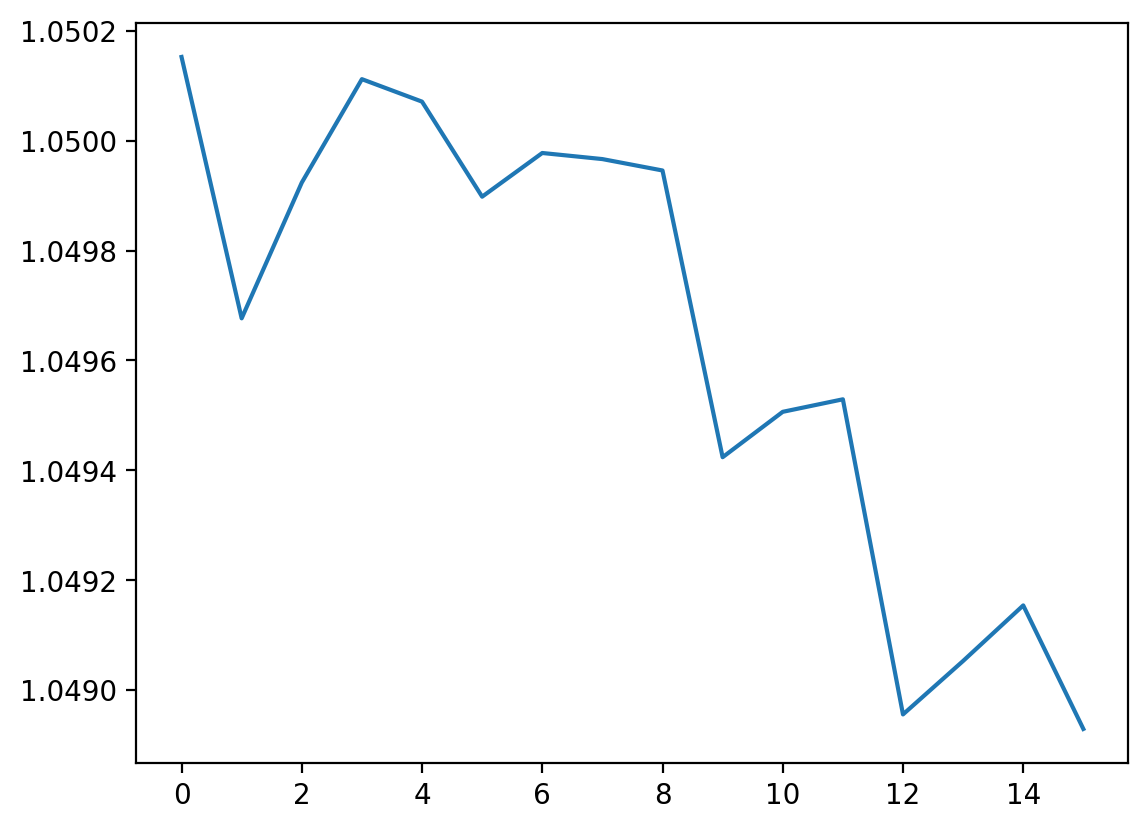

In [19]:
plt.plot(np.arange(0,16),[np.nanmean(gdp_pop_risk_array[i]) for i in range(16)])

In [20]:
test_frame_cutted = test_frame.rio.clip(study_area_gpdframe.geometry, study_area_gpdframe.crs, drop=True)

In [21]:
risk_dataset = xr.Dataset(
    {
        "gdp_pop_risk": (["time", "y", "x"], gdp_pop_risk_array),
    },
    coords={
        "x": (["x"], test_frame_cutted.x.data),
        "y": (["y"], test_frame_cutted.y.data),
        "time": (["time"], [i for i in range(2000,2016)]),
    },
)

In [22]:
risk_dataset.rio.write_crs("epsg:4326", inplace=True)
risk_dataset.rio.write_coordinate_system(inplace=True)
risk_dataset

<xarray.Dataset>
Dimensions:       (time: 16, y: 1587, x: 1482)
Coordinates:
  * x             (x) float64 110.4 110.4 110.4 110.4 ... 122.7 122.7 122.7
  * y             (y) float64 42.61 42.6 42.6 42.59 ... 29.42 29.41 29.41 29.4
  * time          (time) int32 2000 2001 2002 2003 2004 ... 2012 2013 2014 2015
    spatial_ref   int32 0
Data variables:
    gdp_pop_risk  (time, y, x) float32 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0

In [24]:
def do_jenks(data, n_classes):
    import jenkspy
    breaks = jenkspy.jenks_breaks(data, n_classes)
    return breaks

In [25]:
risk_dataset_array = risk_dataset.to_array()
risk_dataset_array = risk_dataset_array.to_numpy()
risk_dataset_array_flatten = risk_dataset_array[~np.isnan(risk_dataset_array)].flatten()

In [29]:
risk_dataset_array_flatten_iidsample = [np.random.choice(risk_dataset_array_flatten, 50000) for _ in range(200)]

In [34]:
levels = Parallel(n_jobs=joblib.cpu_count())(delayed(do_jenks)(i, 5) for i in risk_dataset_array_flatten_iidsample)

In [35]:
levels_array = np.array(levels)
levels_array_mean = np.mean(levels_array, axis=0)
print("final result: ", levels_array_mean)

final result:  [1.        1.        1.1000019 1.3000019 1.5015001 1.799998 ]


In [22]:
risk_dataset.to_netcdf(r"E:\risk_evaluation\scripts\outputs\EC_DAM\GDP_POP_RISK.nc")

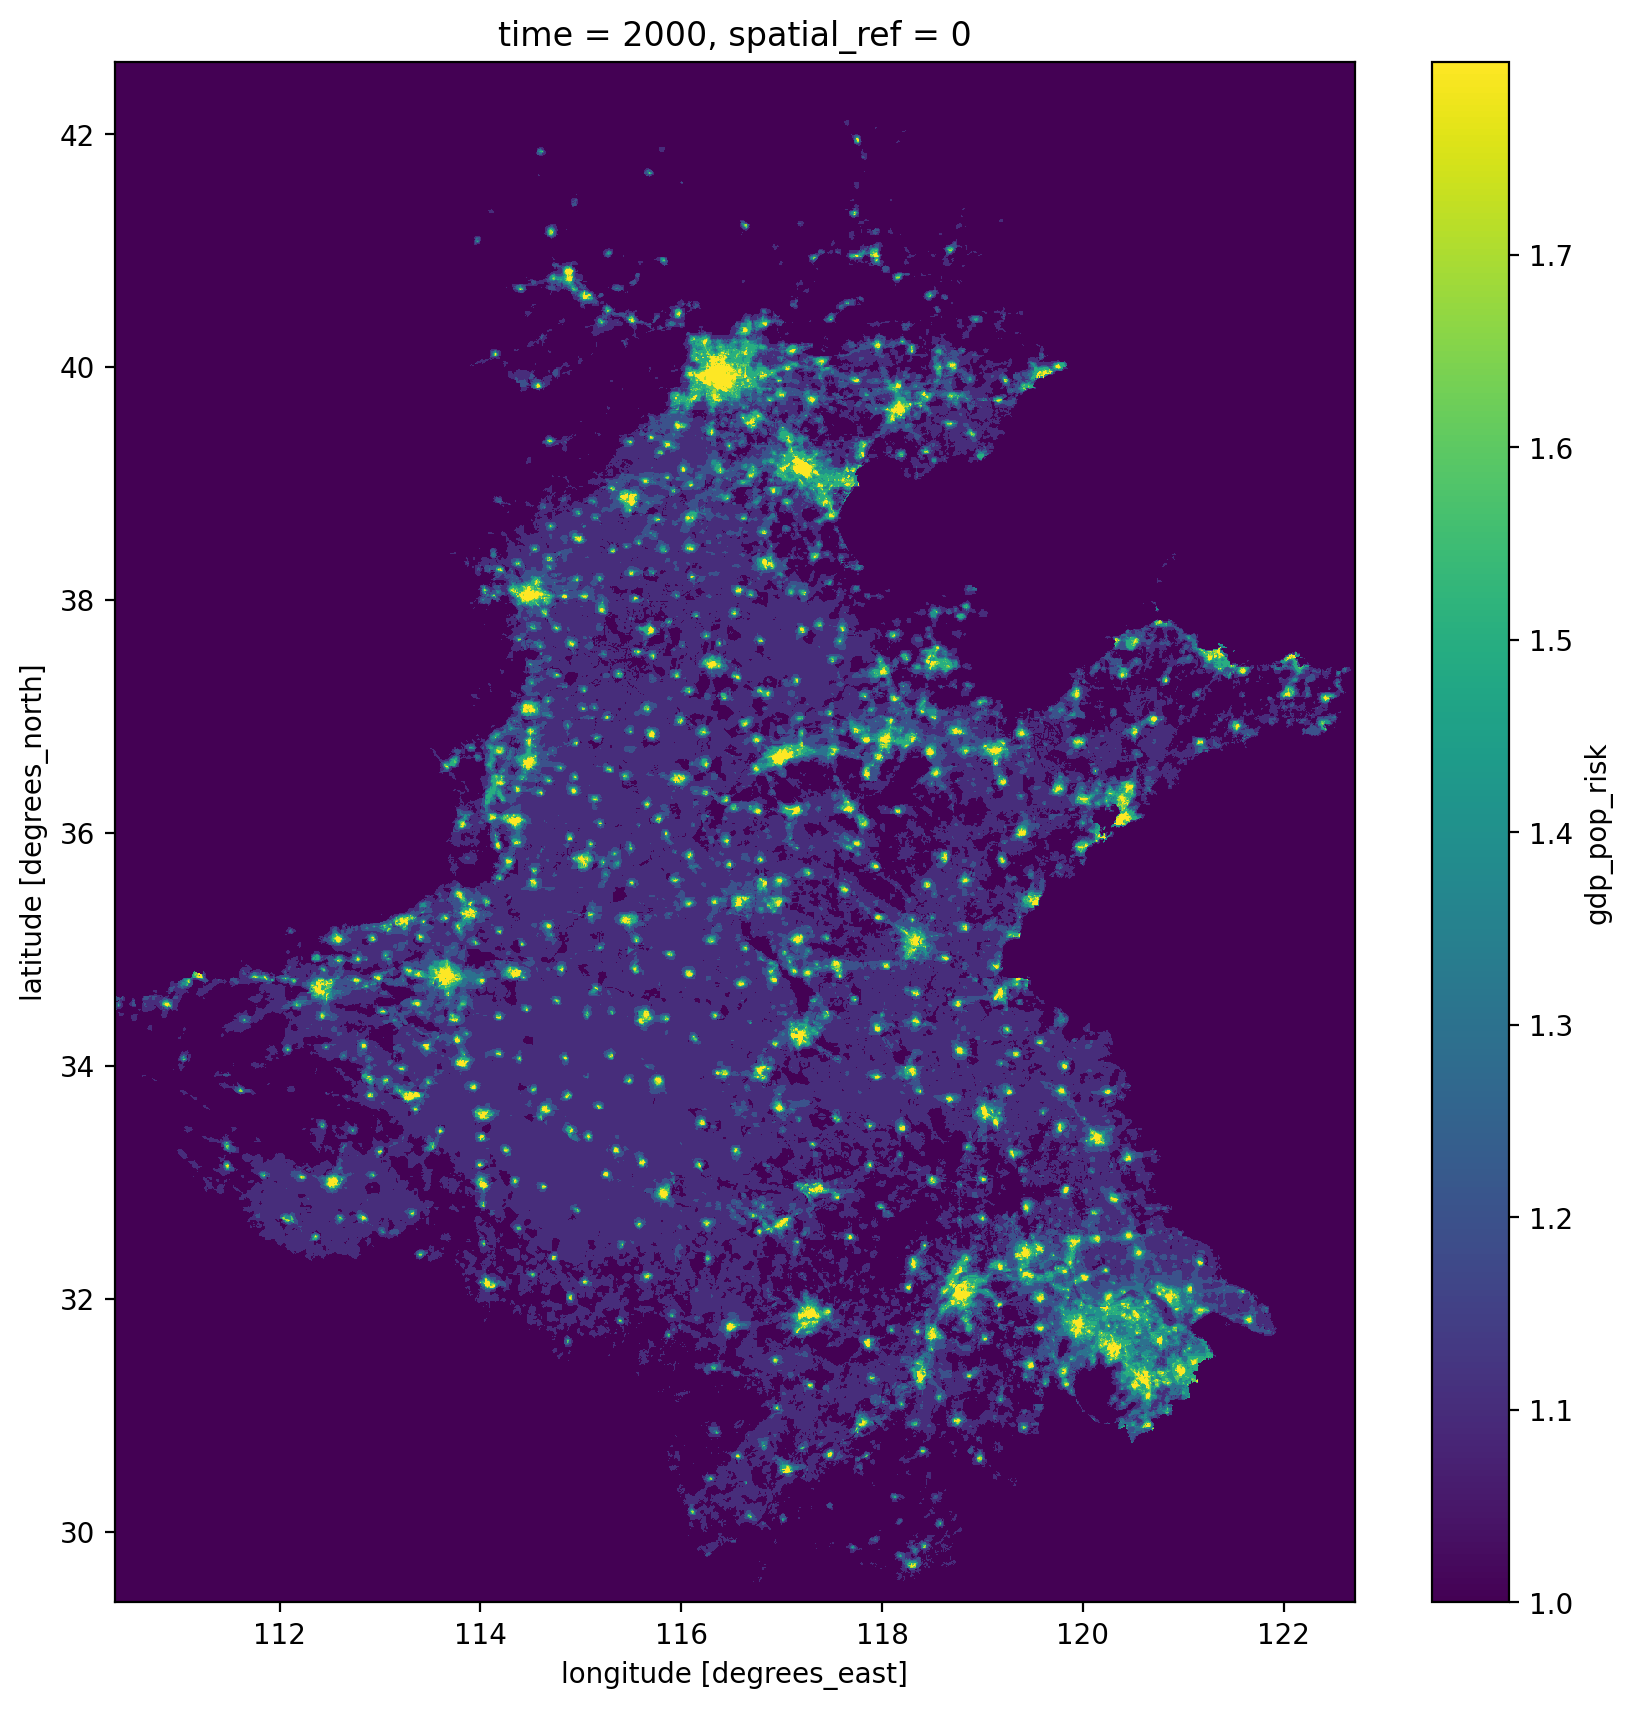

In [23]:
fig,ax = plt.subplots(figsize=(10,10))
risk_dataset.gdp_pop_risk[0].plot(ax=ax)